In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [2]:
device=torch.device('cpu')

In [3]:
# Step 1. Prepare data-1/2
# DataLoader wraps a Dataset and provides minibatches, shuffling, multithreading, for you
data_in=np.loadtxt('./data/Re_100/input_u_fake.dat')
data_out=np.loadtxt('./data/Re_100/output_p.dat')
x=torch.Tensor(data_in)
y=torch.Tensor(data_out)
print(x.size())

torch.Size([204, 6724])


In [4]:
loader=DataLoader(TensorDataset(x, y), batch_size=204)

In [5]:
# Step 2. Create model 建立model習慣建立class
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, B, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear_1=torch.nn.Linear(D_in, H)
        self.linear_2=torch.nn.Linear(H, B)
        self.linear_3=torch.nn.Linear(B, D_out)
    
    # Step 3. Forward pass-1/2    # Step 4. Backward pass-1/2
    def forward(self, x):
        h=self.linear_1(x)
        h_relu=torch.nn.functional.relu(h) #為何activation and hidden layer 的實現方式不同
        b=self.linear_2(h_relu) 
        b_relu=torch.nn.functional.relu(b)
        y_pred=self.linear_3(b_relu) 
        return y_pred
    
model= TwoLayerNet(D_in=6724, H=1000, B=100, D_out=6724)
model=model.to(device) #這行是什麼意思? A:将模型加载到相应的设备

In [7]:
optimizer=torch.optim.Adam(model.parameters(), lr=1e-4)

Epochs:  0 ; Loss:  0.00033289470593445003
Epochs:  100 ; Loss:  0.00013545327237807214
Epochs:  200 ; Loss:  8.530095510650426e-05
Epochs:  300 ; Loss:  5.4840787925058976e-05
Epochs:  400 ; Loss:  3.8665828469675034e-05
Epochs:  500 ; Loss:  3.2389081752626225e-05
Epochs:  600 ; Loss:  2.9072400138829835e-05
Epochs:  700 ; Loss:  2.6209016141365282e-05
Epochs:  800 ; Loss:  2.4275848772958852e-05
Epochs:  900 ; Loss:  2.304793451912701e-05
Epochs:  1000 ; Loss:  2.2288410036708228e-05
Epochs:  1100 ; Loss:  2.1451982320286334e-05
Epochs:  1200 ; Loss:  2.1179719624342397e-05
Epochs:  1300 ; Loss:  1.9488406906020828e-05
Epochs:  1400 ; Loss:  1.749586772348266e-05
Epochs:  1500 ; Loss:  1.5233260455715936e-05
Epochs:  1600 ; Loss:  1.2090915333828889e-05
Epochs:  1700 ; Loss:  9.547118679620326e-06
Epochs:  1800 ; Loss:  7.71066788729513e-06
Epochs:  1900 ; Loss:  6.43211660644738e-06
Epochs:  2000 ; Loss:  6.472409950220026e-06
Epochs:  2100 ; Loss:  5.922214313613949e-06
Epochs:  2

Text(0, 0.5, 'loss')

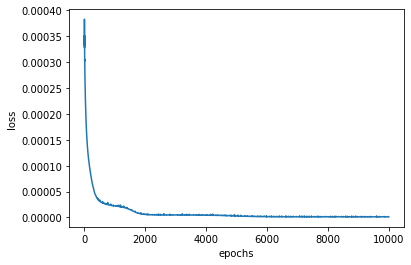

In [9]:
loss_epoch=[]
loss_values = []

for epochs in range(10000):
    
    for x_batch, y_batch in loader:
        # Forward pass
        y_pred=model(x_batch)
        loss=torch.nn.functional.mse_loss(y_pred, y_batch)
        
        # Backward pass
        loss.backward()
        
        # Update Weights
        optimizer.step()
        optimizer.zero_grad()
    
    loss_epoch.append(epochs)
    loss_values.append(loss.item())
    
    if epochs%100==0:
        print("Epochs: ", epochs, "; Loss: ", loss.item())

print("Epochs: ", epochs, "; Loss: ", loss.item())

#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')

In [10]:
PATH= "01_model.pth"
torch.save(model.state_dict(), PATH)